In [1]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


#### **API 키 설정**

#### **웹 검색과 스크래핑 도구 설정**

In [2]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'\n{doc.page_content}\n'
            for doc in docs
        ]
    )

USER_AGENT environment variable not set, consider setting it to identify your requests.


#### **OpenAI의 TTS API를 통한 TTS 도구 설정**

In [3]:
from langchain_core.tools import tool
from openai import OpenAI
from pathlib import Path

@tool
def text_to_speech(text: str, voice: str, output_filename: str) -> str:
    """
    Converts text to speech using OpenAI's TTS API, saving the audio file locally with a dynamic filename.

    Args:
        text (str): The text to convert to speech.
        voice (str): The voice model to use for speech synthesis. Options include:
                     - 'alloy', 'echo', 'fable', 'onyx', 'nova', 'shimmer'.
        output_filename (str): The name for the output audio file, including file extension (e.g., 'output.mp3').

    Returns:
        str: The path to the saved audio file.
    """
    client = OpenAI()
    speech_file_path = Path(output_filename)
    response = client.audio.speech.create(model="tts-1-hd", voice=voice, input=text)
    response.stream_to_file(speech_file_path)
    return str(speech_file_path)


#### **주어진 여러 Segment별 오디오 트랙을 하나의 오디오 파일로 만드는 도구 설정**

In [4]:
from langchain_core.tools import tool
from pydub import AudioSegment
from typing import List

@tool
def edit_podcast_audio(segments: List[str], pauses_between_segments: int = 100, output_filename: str = "final_podcast_episode.mp3") -> str:
    """
    Edits a podcast episode by combining audio segments with specified pauses between them, ensuring consistent volume.

    Args:
        segments (List[str]): List of paths to audio segment files.
        pauses_between_segments (int): Duration of pause between segments in milliseconds. Default is 1000.
        output_filename (str): The name for the output podcast file, including file extension (e.g., 'episode.mp3').

    Returns:
        str: The path to the saved podcast episode.
    """
    podcast_episode = AudioSegment.silent(duration=0)  # Initialize an empty audio segment

    for segment_path in segments:
        segment = AudioSegment.from_file(segment_path)  # Load the segment
        podcast_episode += AudioSegment.silent(duration=pauses_between_segments) + segment  # Append with pause

    podcast_episode = podcast_episode.normalize()  # Normalize volume
    podcast_episode.export(output_filename, format='mp3')  # Export the edited podcast

    return output_filename


/Users/hyeonjinho/.pyenv/versions/3.11.6/lib/python3.11/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


#### **도구 리스트 정의**

In [5]:
# Define the tools we want to use
tools = [
    tavily_tool,  # Built-in search tool via Tavily
    scrape_webpages,
    text_to_speech,  # Our custom text to speech tool
    edit_podcast_audio # Audio Mix Tool
]


#### **하위 에이전트와 Supervisor 에이전트 설정 함수 정의**

In [6]:
from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

#### **Research Team 구성하기**

In [7]:
import functools
import operator
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent

# ResearchTeam graph state
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str


llm = ChatOpenAI(model="gpt-4o-mini")

search_system = """
You are a search specialist in a research team. 
Your role is to use the Tavily search tool to find relevant and up-to-date information on the given topic to generate the podcast.

Your tasks:
1. Analyze the user's request or question.
2. Formulate effective search queries based on the request.
3. Use the Tavily search tool to find information.
4. Summarize the most relevant findings concisely.
5. If the search results are insufficient, consider refining your search query and trying again.

Always strive for accuracy and relevance in your search results. 
If you can't find satisfactory information, be honest about the limitations of your search.
"""

search_agent = create_react_agent(llm, tools=[tavily_tool], state_modifier=search_system)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

webscraper_system = """
You are a web scraping specialist in a research team. 
Your role is to extract detailed information from specific web pages using the scrape_webpages tool.

Your tasks:
1. Analyze the URLs or web pages provided, usually as a result of the Search agent's findings.
2. Use the scrape_webpages tool to extract relevant content from these pages.
3. Process and summarize the scraped content, focusing on the most pertinent information related to the research topic.
4. If the scraped content is not satisfactory, consider requesting different URLs from the Search agent or suggesting refinements to the search query.

Ensure that you respect website terms of service and ethical scraping practices. Always summarize and contextualize the information you scrape, don't just return raw data.
"""

research_agent = create_react_agent(llm, tools=[scrape_webpages], state_modifier=webscraper_system)
research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")

supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Search", "WebScraper"],
)

/var/folders/1x/st3vh8xs6715dcgqc1gk2hhh0000gn/T/ipykernel_60878/4061980305.py:48: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 1.0.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  | llm.bind_functions(functions=[function_def], function_call="route")


#### **Research Team 그래프 구축 및 상위 레이어와의 연결 Chain 정의**

In [8]:
research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("Search", search_node)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("supervisor", supervisor_agent)

# Define the control flow
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("WebScraper", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "WebScraper": "WebScraper", "FINISH": END},
)


research_graph.add_edge(START, "supervisor")
chain = research_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


research_chain = enter_chain | chain

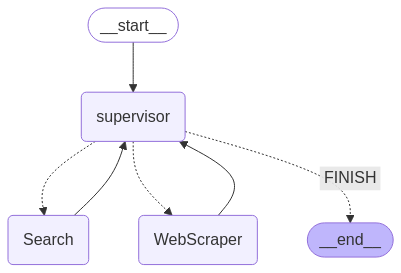

In [9]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

#### **Podcast Team 정의**

In [10]:
# PodcastTeam 그래프 상태
class PodcastTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str
    script: List[dict]
    audio_segments: List[str]

podcast_plan_system="""
You are tasked with creating a structured script for a podcast episode. 
The script should consist of a series of interactions between the host and the guest based on the provided topic and information from the research.
IMPORTANT NOTE: The podcast should have 2 or more speakers to have a conversation.

For each part of the dialogue, clearly specify whether it's the host speaking or the guest. Also, assign a suitable voice model for text-to-speech conversion for each segment. Use the following voice models based on the character:

- Host segments: Use the 'alloy' voice model.
- Guest segments: Use the 'fable' voice model.

The output should be a list where each item is a dictionary with keys 'speaker', 'text', and 'voice', indicating the speaker (host or guest), their line of dialogue, and the voice model to use.

Example output format:
[
    {"speaker": "host", "text": "Welcome to our podcast, where we explore the latest in technology.", "voice": "alloy"},
    {"speaker": "guest", "text": "Thank you for having me, it's great to be here to share my experiences.", "voice": "fable"},
    {"speaker": "host", "text": "Can you tell us about your current project?", "voice": "alloy"},
    {"speaker": "guest", "text": "Certainly! I've been working on a new AI platform that...", "voice": "fable"},
    ...
]

Your task is to generate a similar structured script in **KOREAN**,
ensuring each dialogue segment between the host and guest is well-defined and allocates the appropriate voice model for the text-to-speech conversion process.

"""
podcast_planner_agent = create_react_agent(
    llm, state_modifier=podcast_plan_system,tools=[tavily_tool]
)
podcast_planner_node = functools.partial(agent_node, agent=podcast_planner_agent, name="PodcastPlanner")

# AudioProducer 에이전트
audio_producer_system="""
You are responsible for producing the final audio for the podcast episode. 
Take the structured script provided by the Podcast Planner, which contains segments marked with 'speaker' (either 'host' or 'guest'), the 'text' for each segment, and the 'voice' model to use.

For each segment, use the 'text_to_speech' tool to generate audio, specifying the 'text' and 'voice' as provided. 
Ensure each segment is saved as a separate audio file.

After generating all segments, use the 'edit_podcast_audio' tool to combine these audio files into one seamless podcast episode. 
The audio files should be combined in the order they are provided in the script, with appropriate pauses between segments to simulate a natural conversation flow.

Your output should be the path to the final combined podcast episode audio file.
"""
audio_producer_agent = create_react_agent(
    llm,
    [text_to_speech, edit_podcast_audio], state_modifier=audio_producer_system
)
audio_producer_node = functools.partial(agent_node, agent=audio_producer_agent, name="AudioProducer")

# 팀 감독자 생성
podcast_supervisor = create_team_supervisor(
    llm,
    """You are a supervisor tasked with managing the podcast creation process.
    Your team consists of a PodcastPlanner and an AudioProducer.
    Given the current state, decide which team member should act next or if the process is complete.
    Respond with 'PodcastPlanner', 'AudioProducer', or 'FINISH'.""",
    ["PodcastPlanner", "AudioProducer"]
)

#### **Podcast Team 그래프 및 상위 레이어와의 연결 Chain 정의**

In [11]:
podcast_graph = StateGraph(PodcastTeamState)
podcast_graph.add_node("PodcastPlanner", podcast_planner_node)
podcast_graph.add_node("AudioProducer", audio_producer_node)
podcast_graph.add_node("supervisor", podcast_supervisor)

# 제어 흐름 정의
podcast_graph.add_edge("PodcastPlanner", "supervisor")
podcast_graph.add_edge("AudioProducer", "supervisor")
podcast_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"PodcastPlanner": "PodcastPlanner", "AudioProducer": "AudioProducer", "FINISH": END},
)
podcast_graph.add_edge(START, "supervisor")

chain = podcast_graph.compile()

# 상위 레벨 그래프 상태와 팟캐스트 서브그래프 상태 간의 상호 운용을 위한 함수
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ["PodcastPlanner", "AudioProducer"],
        "next": "",
        "script": [],
        "audio_segments": []
    }
    return results

podcast_chain = enter_chain | chain

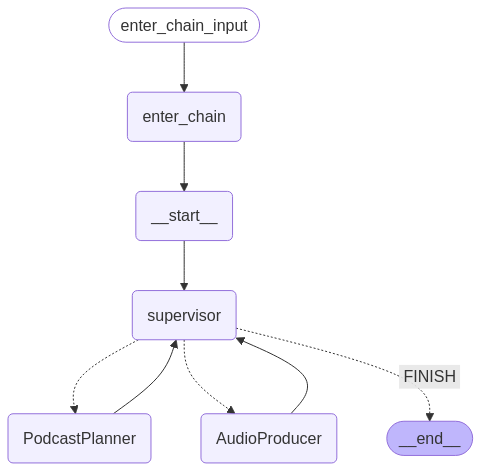

In [12]:
from IPython.display import Image, display

display(Image(podcast_chain.get_graph().draw_mermaid_png()))

#### **상위 레이어의 Supervisor 정의하기**

In [13]:
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["ResearchTeam", "PodcastTeam"],
)

#### **상위 레이어 그래프 구축하기**

In [14]:
# Top-level graph state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str


def get_last_message(state: State) -> str:
    return state["messages"][-1].content


def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}


# Define the graph.
super_graph = StateGraph(State)
# First add the nodes, which will do the work
super_graph.add_node("ResearchTeam", get_last_message | research_chain | join_graph)
super_graph.add_node(
    "PodcastTeam", get_last_message | podcast_chain | join_graph
)
super_graph.add_node("supervisor", supervisor_node)

# Define the graph connections, which controls how the logic
# propagates through the program
super_graph.add_edge("ResearchTeam", "supervisor")
super_graph.add_edge("PodcastTeam", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "PodcastTeam": "PodcastTeam",
        "ResearchTeam": "ResearchTeam",
        "FINISH": END,
    },
)
super_graph.add_edge(START, "supervisor")
super_graph = super_graph.compile()

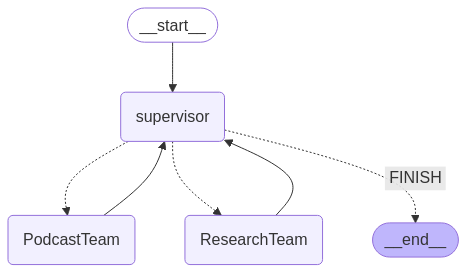

In [15]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

In [16]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="OpenAI가 최근에 출시한 o1 모델과 AI 에이전트"
            )
        ],
    },
    {"recursion_limit": 150},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'ResearchTeam'}}
---
{'ResearchTeam': {'messages': [HumanMessage(content='### OpenAI의 o1 모델과 AI 에이전트 분석\n\n#### OpenAI o1 모델\nOpenAI는 최근에 o1 모델을 발표했습니다. 이 모델은 2024년 9월에 출시될 예정이며, 주요 기능으로는 STEM 분야(과학, 기술, 공학, 수학)의 복잡한 문제 해결을 지원하는 데 초점을 맞추고 있습니다. \n\n- **기능 및 기술**: o1 모델은 GPT-4o 기술을 기반으로 하며, "순차적 괴리" 기능을 통해 문제가 해결되는 다양한 접근 방식을 지원합니다. 이는 사용자와의 상호작용을 원활하게 만들어, 쉽게 접근하고 커스터마이즈할 수 있게 설계되었습니다.\n- **API와 개발 환경**: 개발자들은 o1 모델과 API를 통해 다양한 애플리케이션을 개발하고, 이를 통해 ChatGPT와 동일한 방식으로 사용하고 통합할 수 있습니다. API는 사용자가 데이터를 쉽게 다루고, 기능을 구현할 수 있게 돕습니다.\n\n#### AI 에이전트\nOpenAI는 AI 에이전트의 개발에 박차를 가하고 있으며, 이들은 자연어 명령을 이해하고 최소한의 사용자 감독으로 복잡한 작업을 수행하는 능력을 갖추고 있습니다. \n\n- **AI 에이전트의 목표 및 기능**: AI 에이전트는 사용자의 다양한 요청을 수행하여 일상 생활의 자동화를 가능하게 하며, 예를 들어 스케줄 정리, 레시피 추천, 금융 관리 등을 지원합니다. 이러한 기능은 결국 사용자에게 보다 맞춤화된 경험을 제공하는 데 기여할 것입니다.\n- **자금 조달과 개발**: OpenAI는 최근 66억 달러를 조달하여 AI 에이전트의 개발을 가속화하고 있으며, 이는 AI 개발을 위한 컴퓨팅 자원에 대한 접근성을 향상시키기 위한 것입니다.\n\n#### 기술적 혁신과 안전성\nOpenAI는 AI 에이전트의 실제적 적용을 위해 다양한 기술적 혁신을 도입하고 있

In [78]:
super_graph.get_state

<bound method Pregel.get_state of <langgraph.graph.state.CompiledStateGraph object at 0x000001A6B33E7CD0>>